Ex 1 - Romberg Integration:

In [1]:
def romb_km(func, a, b, k, m, *args):
    # calculates Rkm
    """
    Parameters:
    --------------------------------
    func - python function object
           function to integrate
    a, b - floats
           integration interval
    k, m - int 
           parameters in R_{k,m}
    args - list
           a list of parameters to pass to func
           parameters must be in order and number expected by func

    Returns:
    ---------------------------------
    Rkm  - (k+1)x(m+1) float matrix
           the R_{k,m} values for k,m=0,1,2,...
    """
    Rkm = np.array( [[0] * (m+1)] * (k+1), float ) # initialize Rkm matrix with zeroes
    h = b - a # we use only the two edge points at first
    Rkm[0,0] = 0.5 * h * ( func(a, *args) + func(b, *args) ) # trapezoidal with just the two edges
    for i in xrange(1, k+1):
        h *= 0.5 # the new step size is half the previous
        sd = 0. # sum for k>0
        for k in xrange(1, 2**i, 2): # step 2 to add only the new points in-between the old from previous subdivision
            sd += func( a+k*h, *args ) # the summation term in Rk0
            Rkm[i,0] = 0.5 * Rkm[i-1,0] + h * sd # evaluation of Rk0
        for j in xrange( 1, i + 1):
            fact = 4.**j
            Rkm[i,j] = ( fact*Rkm[i,j-1] - Rkm[i-1,j-1] ) / ( fact - 1 ) # recurance relation to evalutate Rkm         
    return Rkm

In [2]:
def romberg(func, a, b, rtol, *args):
    # calculates the integral to the required accuracy
    """
    Parameters:
    --------------------------------
    func - python function object
           function to integrate
    a, b - floats
           integration interval
    rtol - float 
           fractional tolerance of the integral estimate
    args - list
           a list of parameters to pass to func
           parameters must be in order and number expected by func

    Returns:
    ---------------------------------
    I    - float
           estimate of the integral for input f, [a,b] and rtol
    m    - int
           number of iterations to achive desired accuracy
    """
    # testing error tolerance
    mtol = 1
    Rkm = romb_km(func, a, b, mtol, mtol, *args)
    while np.abs( Rkm[mtol,mtol] - Rkm[mtol,mtol-1] ) > rtol: 
        mtol += 1
        Rkm = romb_km(func, a, b, mtol, mtol, *args)
    return Rkm[mtol,mtol], mtol

In [3]:
# function to integrate in order to check if the above Romberg method works
import numpy as np
def f(x):
    return np.exp(x)

In [4]:
import numpy as np

# find machine accuracy
macheps = 1.0; verbose = False; 
while ((1.0 + (macheps)) != 1.0): # while computer can tell between 1 and 1+eps/2
    if verbose: 
        print("epsilon = %.16e , 1+epsilon = %.16e"%(macheps, 1.0+macheps))
    macheps /= 2. # keep dividing by 2

# calculate integral of exp(x) for machine accuracy
a = 0.; b = 1.; rtol = macheps
I_exact = np.exp(b) - np.exp(a)
I_romb, mtol = romberg(f, a, b, rtol)
frac_error = np.abs( I_romb / I_exact ) - 1.
print("Romberg integration result = %.9f"%(I_romb))
print("Exact integration result = %.9f"%(I_exact))
print("Number of iterations = %d"%(mtol))
print("Fractional error = %.3e"%(frac_error))

Romberg integration result = 1.718281828
Exact integration result = 1.718281828
Number of iterations = 5
Fractional error = 4.441e-16


As we can see, the Romberg methods we developed seems to be working. After just $5$ iterations it provided an estimation for the integral at machine accuracy, when compared to the analytic value of the same integral.

Ex 2a - Power spectrum integration:

It is convenient to transform the given integral from linear to logarithim scale, i.e. to apply the transformation $u = \log k$ (and thus, $dk = \ln(10) 10^u du$). Then the integral becomes
$$\sigma^2 (R) = \frac{\ln (10)}{2\pi^2} \int _{-\infty}^\infty 10^{3u} P(10^u) \tilde{W}_{TH}^2 (10^u R) du \; .$$
In order to be able to integrate this analytically we need to get rid of the infinities. In the figure below we can see an example of what type of functions we are going to integrade. From this, it is obvious that we can choose a minimum, $k_{\min}$ and a maximum, $k_{\max}$, wavenumber to use instead of $\pm \infty$, since the function outside these limits takes very small values, and thus they contribute little to the result. So, lets take $k_{\min} = 10^{-5} \; h \; Mpc^{-1}$ and $k_{\max} = 10^2 \; h \; Mpc^{-1}$.

Also, it is convenient to use logarithmic spacing for the values of $R$.

In [5]:
# defining the functions we are going to use
from colossus.cosmology import cosmology
def Wth(x, R):
    # top-hat window function
    xi = R*x
    return 3.*(np.sin(xi)-xi*np.cos(xi)) / xi**3.
def Pw(x):
    # power spectrum from colossus
    return cosmo.matterPowerSpectrum(x, 'eh98')
def lnfpwsp(x, R):
    # integrant of ex 2 in ln spacing
    return np.e**(3.*x)*Pw(np.e**x)*Wth(np.e**x, R)**2. / (2.*np.pi**2.)
def lfpwsp(x, R):
    # integrant of ex 2 in log spacing
    return 10.**(3.*x)*Pw(10.**x)*Wth(10.**x, R)**2. * ( np.log(10) / (2.*np.pi**2.) )
def linfpwsp(x, R):
    # integrant of ex 2 in linear spacing
    return x**2.*Pw(x)*Wth(x, R)**2. / (2.*np.pi**2.)

R = 1.000e-01


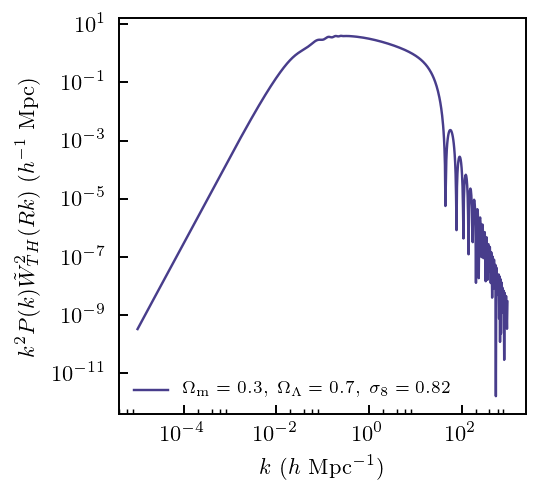

In [6]:
# define the cosmology we are going to work with (kept everything the same as in notes)
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
z = 0.0

# set my_cosmo to be the current cosmology; 
# setCosmology returns a colossus cosmology object with useful functions
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
# switch off internal colossus spline interpolation
cosmo.interpolation = False

# define the range of wavenumbers k 
kmin = 1.e-5; kmax = 1.e+3; dk = 1.e-2; R = 1.e-1
lkmin = np.log10(kmin); lkmax = np.log10(kmax)

# set up vectors of k with even spacing and log10 spacing (klog)
k = np.arange(kmin, kmax, dk)
lk = np.arange(lkmin, lkmax, 0.01); klog = 10.0**lk

print("R = %.3e"%(R))
# plot P(k)
import matplotlib.pyplot as plt
%matplotlib inline
from code.plot_utils import plot_pretty
plot_pretty()

plt.figure(figsize=(3,3))
plt.xlabel(r'$k\ (h\ \mathrm{Mpc^{-1}})$'); plt.ylabel(r'$k^2 P(k) \tilde{W}_{TH}^2 (Rk)\ (h^{-1}\ \mathrm{Mpc})$')
plt.xscale('log'); plt.yscale('log')
plt.plot(klog, linfpwsp(klog, R), lw = 1., c='darkslateblue', 
            label=r'$\Omega_{\rm m}=%.1f,\ \Omega_\Lambda=%.1f,\ \sigma_8=%.2f$'%(cosmo.Om0,cosmo.OL0,cosmo.sigma8))

plt.legend(frameon=False, loc='lower left', fontsize=7)
plt.show()

Below we will integrate to derive sigma for various R values using the Romberg integration implementation from Exercise 1 and scipy's romberg routine.

We also compare the results of these two methods by directly comparing their results and by comparing how long it took each method to finish with the calculations

In [7]:
# setup parameters
import time
from scipy import integrate

# log spacing for R:
Rmin = 1.e-2; Rmax = 1.e+3
lRmin = np.log10(Rmin); lRmax = np.log10(Rmax)
lR = np.linspace(lRmin, lRmax, 20); Rlog = 10.0**lR

# log spacing for k:
kmin = 1.e-5; kmax = 1.e+3
lkmin = np.log10(kmin); lkmax = np.log10(kmax)
lk = np.linspace(lkmin, lkmax, 800); klog = 10.0**lk

# log spacing for rtol:
rtolmin = 1.e-12; rtolmax = 1.e-2
lrtolmin = np.log10(rtolmin); lrtolmax = np.log10(rtolmax)
lrtol = np.arange(lrtolmin, lrtolmax, 2.); rtollog = 10.0**lrtol

In [9]:
"""
Here is where all the calculations are done. Namely, we integrate the function given using the Romberg implementation 
of Exercise 1 and also scipy's Romberg routine. 
We repeat this for a number of R values and for each value we try different error tolerance values.
We also time each of these integrations to compare the two integration routines on that aspect.
"""
# define a vector of cosmological parameters (same as in notes):    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
z = 0.0

# set my_cosmo to be the current cosmology; 
# setCosmology returns a colossus cosmology object with useful functions
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
# switch off internal colossus spline interpolation
cosmo.interpolation = False

# initialize array of sigma values
sigmamy = np.array( [ [0] * len(Rlog) ] * len(rtollog), float )
# initialize array containing results from scipy's romberg
sigmapy = np.array( [ [0] * len(Rlog) ] * len(rtollog), float )
# initialize array of fractional errors
frac_err_romb = np.array( [ [0] * len(Rlog) ] * len(rtollog), float )
# initialize array of fractional errors
dtmy = np.array( [ [0] * len(Rlog) ] * len(rtollog), float )
# initialize array of fractional errors
dtpy = np.array( [ [0] * len(Rlog) ] * len(rtollog), float )
# in all of the above -> rows:diff. R values, columns:diff. rtol

for j in range(len(rtollog)):
    # calculate sigma with my Romberg implemetation routine and time each calculation for different R and rtol values
    for i in range(len(Rlog)):
        tmy1 = time.time()
        myint, m = romberg(lfpwsp, lkmin, lkmax, rtollog[j], Rlog[i])
        tmy2 = time.time()
        sigmamy[j,i] = np.sqrt(myint)
        dtmy[j,i] = tmy2 - tmy1 # time duration of each integration all R values and for each rtol using my Romberg 

    # calculate sigma with scipy's Romberg implemetation routine and time each calculation for different R and rtol values
    for i in range(len(Rlog)):
        tpy1 = time.time()
        pyint = integrate.romberg(lfpwsp, lkmin, lkmax, args=(Rlog[i],),tol=rtollog[j])
        tpy2 = time.time()
        sigmapy[j,i] = np.sqrt(pyint)
        dtpy[j,i] = tpy2 - tpy1 # time duration of each integration for every R and each rtol using scipy's Romberg

    # fractional errors for each R and rtol
    for i in range(len(Rlog)):
        frac_err_romb[j,i] = sigmamy[j,i]/sigmapy[j,i] - 1.

In [10]:
# below sigma_my are the sigma values using our Romberg implementation routine
# and sigma_py are the same values calculated using scipy's Romberg routine.
# also the fractional error of the two results is printed out
print("Integration interval is [kmin,kmax] = [%.1e, %.1e]"%(kmin, kmax))
print('****************')
for j in range(len(rtollog)):
    print("rtol = %.3e"%(rtollog[j]))
    print('==========')
    for i in range(len(Rlog)):
        print("For R = %.3e sigma_my = %.9f and sigma_py = %.9f"%(Rlog[i],sigmamy[j,i],sigmapy[j,i]))
        print("Fractional error = %.3e"%(frac_err_romb[j,i]))
        print('--------')

Integration interval is [kmin,kmax] = [1.0e-05, 1.0e+03]
****************
rtol = 1.000e-12
For R = 1.000e-02 sigma_my = 7.997819958 and sigma_py = 7.997819954
Fractional error = 5.238e-10
--------
For R = 1.833e-02 sigma_my = 7.143160666 and sigma_py = 7.143160659
Fractional error = 9.448e-10
--------
For R = 3.360e-02 sigma_my = 6.315084243 and sigma_py = 6.315084235
Fractional error = 1.236e-09
--------
For R = 6.158e-02 sigma_my = 5.517153045 and sigma_py = 5.517154175
Fractional error = -2.048e-07
--------
For R = 1.129e-01 sigma_my = 4.753404267 and sigma_py = 4.753404249
Fractional error = 3.802e-09
--------
For R = 2.069e-01 sigma_my = 4.028553515 and sigma_py = 4.028553471
Fractional error = 1.109e-08
--------
For R = 3.793e-01 sigma_my = 3.348082155 and sigma_py = 3.348082154
Fractional error = 1.386e-10
--------
For R = 6.952e-01 sigma_my = 2.718194794 and sigma_py = 2.718194722
Fractional error = 2.655e-08
--------
For R = 1.274e+00 sigma_my = 2.145544692 and sigma_py = 2.14

In general, the two routines seem to be producing similar results. Esecially for smaller rtol values, the two results are in very good agreement, as we can see from above. This can also be seen visually from the figures below where we plot $\sigma (R)$ for various error tolerance values.

rtol = 1.000e-12


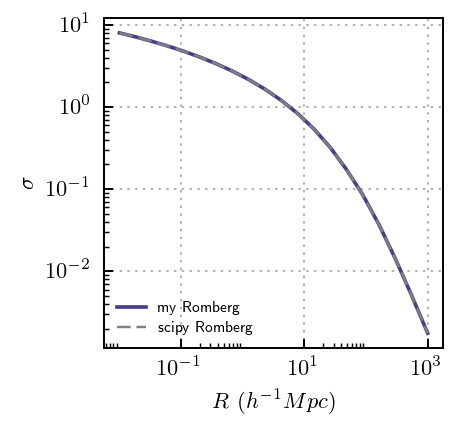

rtol = 1.000e-10


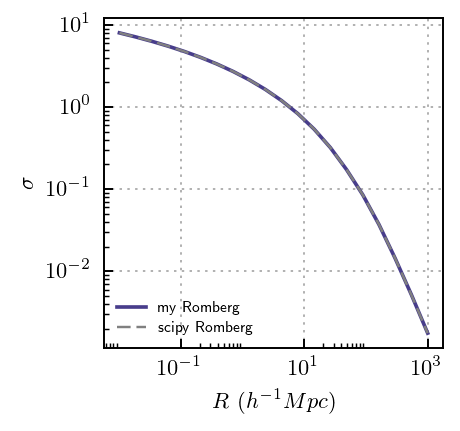

rtol = 1.000e-08


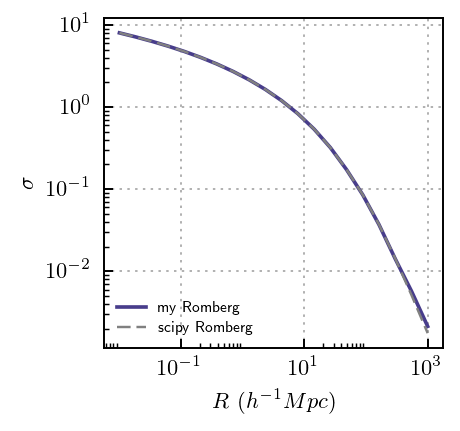

rtol = 1.000e-06


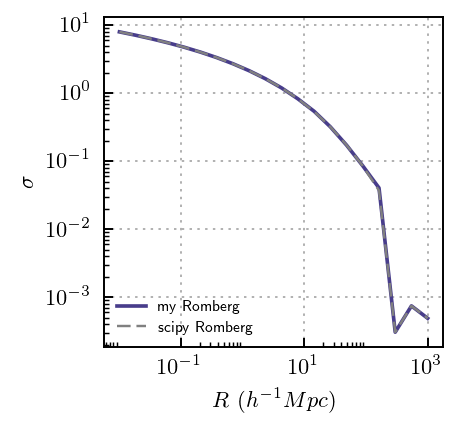

rtol = 1.000e-04


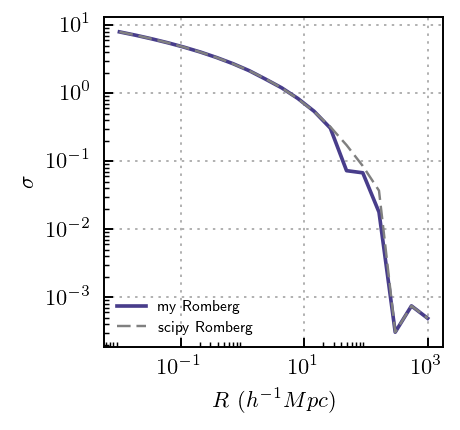

In [11]:
# plot of sigma as a function of R for both integration methods used and for various rtol values
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty

plot_pretty()

for j in range(len(rtollog)):
    print("rtol = %.3e"%(rtollog[j]))
    # plot of sigma as a function of R for each rtol
    plt.figure(figsize=(2.5,2.5))
    #plt.title('derivative error')
    plt.xlabel(r'$R \ (h^{-1} Mpc)$'); plt.ylabel(r'$\sigma$')
    plt.xscale('log'); plt.yscale('log')
    plt.plot(Rlog, sigmamy[j,:], linewidth=1.5, c='darkslateblue', label='my Romberg')
    plt.plot(Rlog, sigmapy[j,:], '--', linewidth=1., c='gray', label='scipy Romberg')
    plt.legend(loc='lower left', frameon=False, fontsize=6)
    plt.grid(ls='dotted')
    plt.show()

For R = 1.000e-02


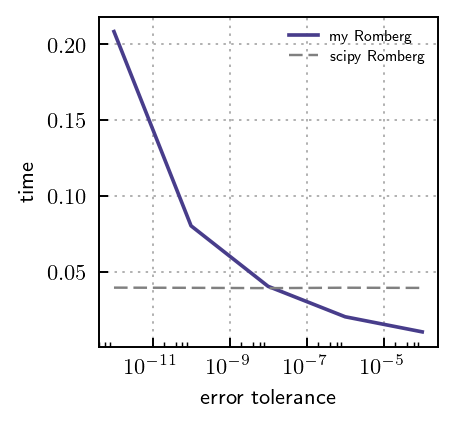

For R = 1.833e-02


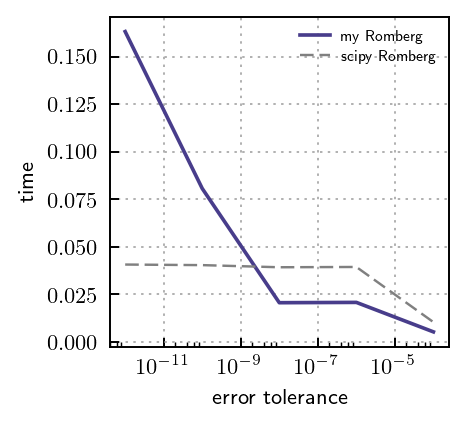

For R = 3.360e-02


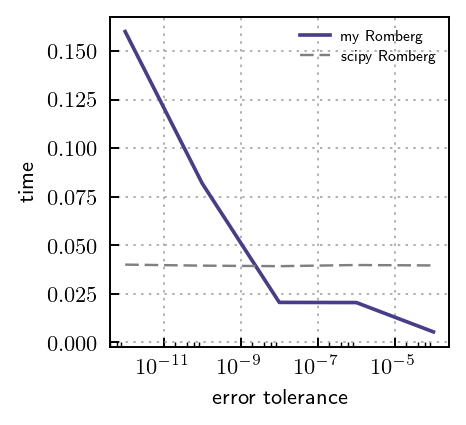

For R = 6.158e-02


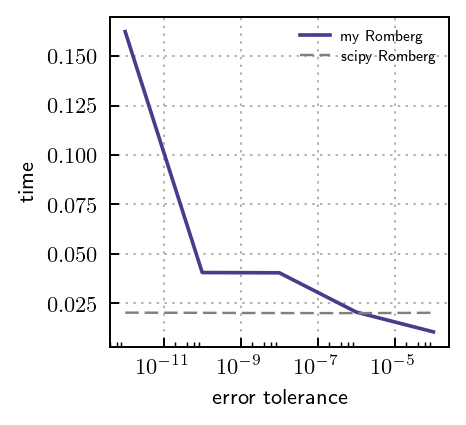

For R = 1.129e-01


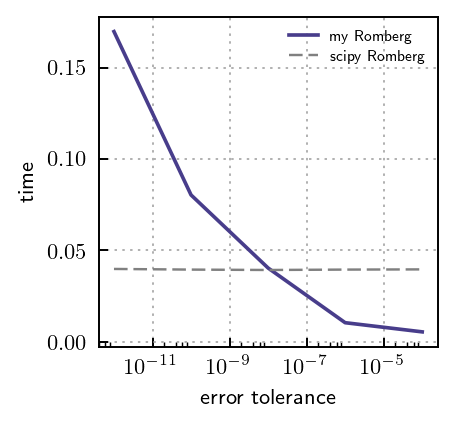

For R = 2.069e-01


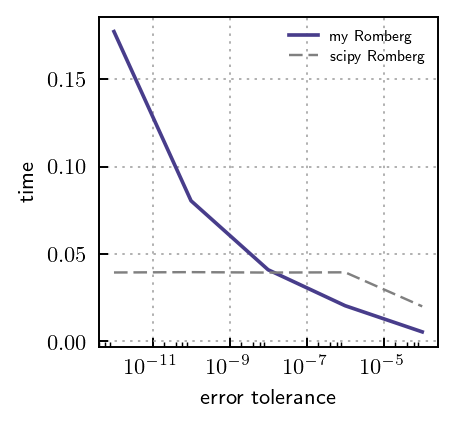

For R = 3.793e-01


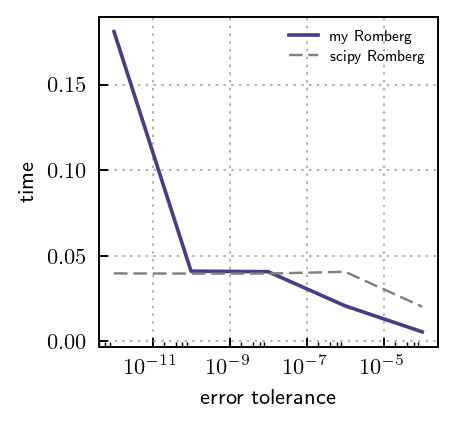

For R = 6.952e-01


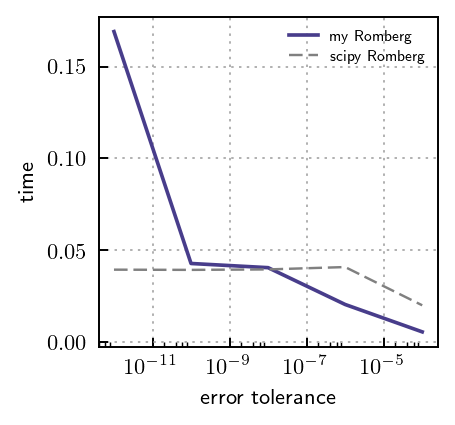

For R = 1.274e+00


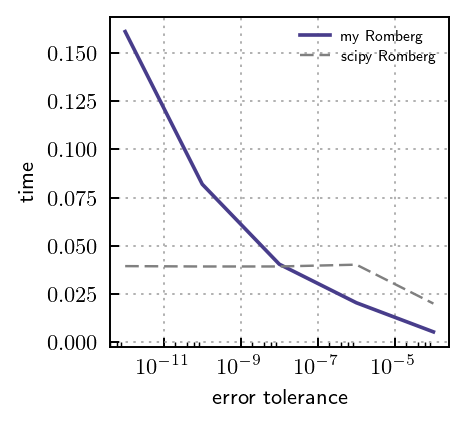

For R = 2.336e+00


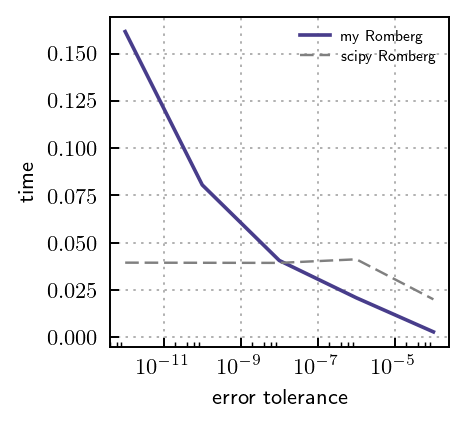

For R = 4.281e+00


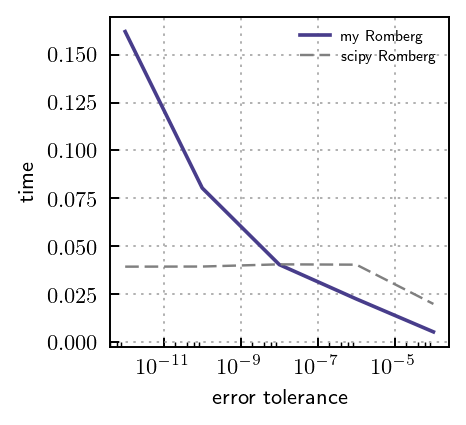

For R = 7.848e+00


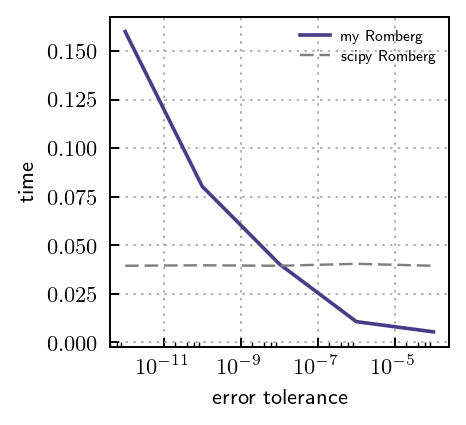

For R = 1.438e+01


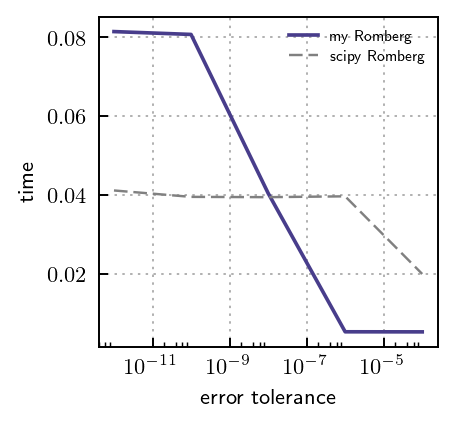

For R = 2.637e+01


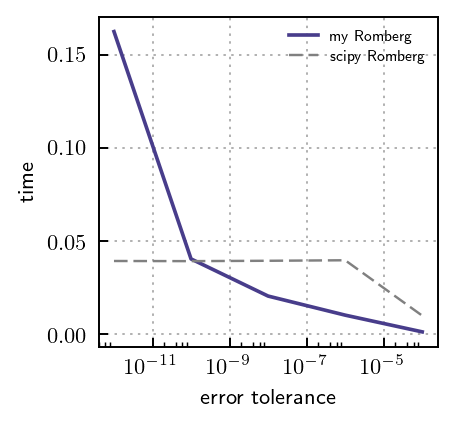

For R = 4.833e+01


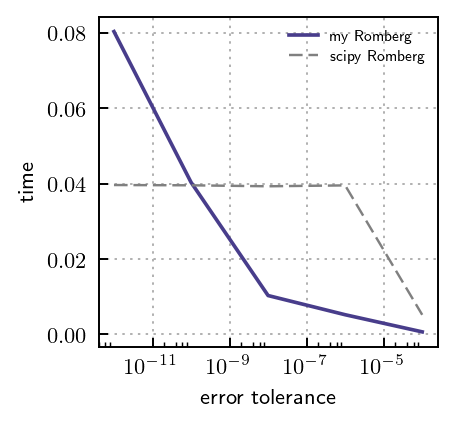

For R = 8.859e+01


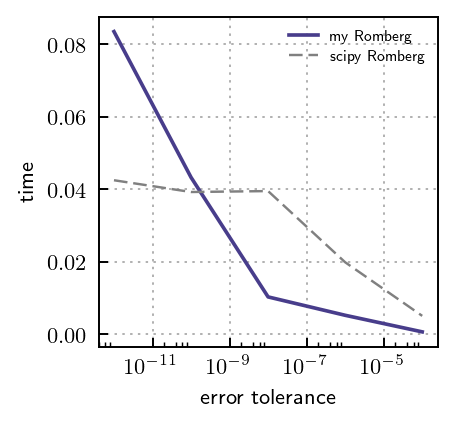

For R = 1.624e+02


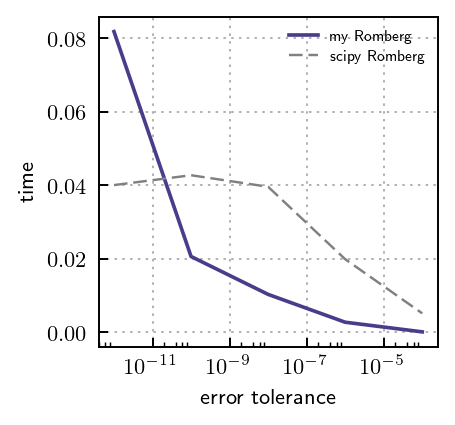

For R = 2.976e+02


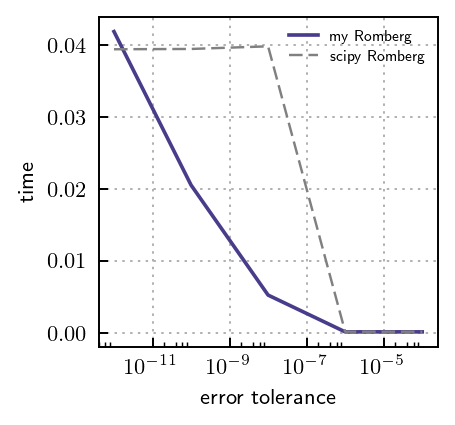

For R = 5.456e+02


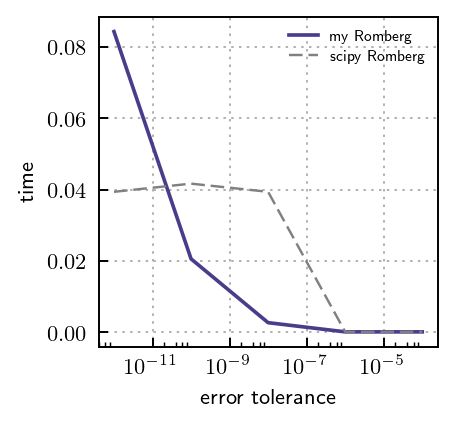

For R = 1.000e+03


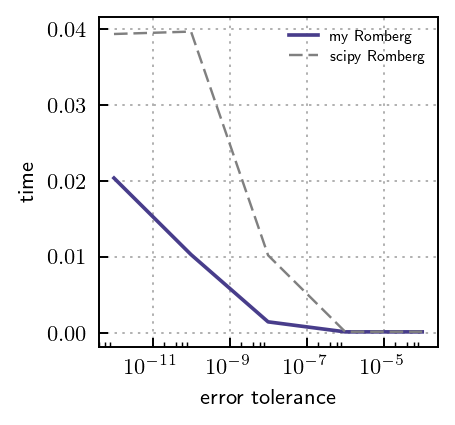

In [12]:
# plot of time duration as a function of R for different rtol values
plot_pretty()

for j in range(len(Rlog)):
    print("For R = %.3e"%(Rlog[j]))
    # now plot the fractional error as a function of step size
    plt.figure(figsize=(2.5,2.5))
    #plt.title('derivative error')
    plt.xlabel(r'error tolerance'); plt.ylabel(r'time')
    plt.xscale('log'); plt.yscale('linear')
    plt.plot(rtollog, dtmy[:,j], linewidth=1.5, c='darkslateblue', label='my Romberg')
    plt.plot(rtollog, dtpy[:,j], '--', linewidth=1., c='gray', label='scipy Romberg')
    plt.legend(loc='upper right', frameon=False, fontsize=6)
    plt.grid(ls='dotted')
    plt.show()

We can see that the smaller the rtol values are the faster scipy's implementation is compared to our implementation in question 1. For higher error tolerance their difference in time duration becomes decreases and eventually become somewhat comparable for the larger rtol values we used here.

Ex 2b - spline integration

In [13]:
# interpolation of integrant in linear and ln spacing
from scipy.interpolate import UnivariateSpline

# integration limits
kmin = 1.e-5; kmax = 1.e+3
# number of points for splines
Nsp = 1000
R = 1.e0

# linear spacing for k
k = np.linspace(kmin, kmax, Nsp)

# ln spacing for k:
lnkmin = np.log(kmin); lnkmax = np.log(kmax)
lnk = np.linspace(lnkmin, lnkmax, Nsp); kln = np.e**lnk

# integration using Romberg implementation (ln spacing)
rtol = 1.e-7
romb_dir, m = romberg(lnfpwsp, lnkmin, lnkmax, rtol, R)
sigmaromb = np.sqrt(romb_dir)
print("Direct integration using our Romberg routine gives sigma = %.9f for R = %.3e and rtol = %.3e"%(sigmaromb, R, rtol))

Direct integration using our Romberg routine gives sigma = 2.367299754 for R = 1.000e+00 and rtol = 1.000e-07


In [14]:
# testing the above for a value of R
print("For R = %.3e and N = %d interpolation points:"%(R, Nsp))

# spline approximation of integral in linear spacing
fklin = linfpwsp(k, R)
fsplin = UnivariateSpline(k, fklin, s=0.)
linfsp = fsplin.integral(kmin, kmax)
sigmasplin = np.sqrt(linfsp)
print("Interpolation with linear spacing gives sigma = %.9f"%(sigmasplin))

# spline approximation of integral in ln spacing
fkln = lnfpwsp(lnk, R)
fspln = UnivariateSpline(lnk, fkln, s=0.)
lnfsp = fspln.integral(lnkmin, lnkmax)
sigmaspln = np.sqrt(lnfsp)
print("Interpolation with ln spacing gives sigma = %.9f"%(sigmaspln))

frerrlin = linfsp/romb_dir - 1.
frerrln = lnfsp/romb_dir - 1.
print("Fractional error for linear interpolation = %.9f"%(frerrlin))
print("Fractional error for ln interpolation = %.9f"%(frerrln))

For R = 1.000e+00 and N = 1000 interpolation points:
Interpolation with linear spacing gives sigma = 2.104197565
Interpolation with ln spacing gives sigma = 2.367307414
Fractional error for linear interpolation = -0.209928272
Fractional error for ln interpolation = 0.000006471


In [41]:
"""
Now we want to test how many points we need to interpolate the function with to achieve the same accuracy
as the direct integration with our Romberg routine.
We will test this for rtol as chosen above for both linear and ln spacing.
"""
# linear spacing interpolation
Nlin = 5; # initial number of interpolation points
k = np.linspace(kmin, kmax, Nlin)
fklin = linfpwsp(k, R)
fsplin = UnivariateSpline(k, fklin, s=0.)
linfsp = fsplin.integral(kmin, kmax)
sigmasplin = np.sqrt(linfsp) # first integral approximation for few points
oldsigmasplin = 0
while np.abs( sigmasplin - oldsigmasplin ) > rtol:
    oldsigmasplin = sigmasplin
    Nlin += 1 # increase number of interpolating points
    k = np.linspace(kmin, kmax, Nlin)
    fklin = linfpwsp(k, R)
    fsplin = UnivariateSpline(k, fklin, s=0.)
    linfsp = fsplin.integral(kmin, kmax)
    sigmasplin = np.sqrt(linfsp)

print("Number of points needed to reach accuracy rtol with linear spacing = %d"%(Nlin))

Number of points needed to reach accuracy rtol with linear spacing = 3386


In [43]:
# ln spacing interpolation
Nln = 5
lnk = np.linspace(lnkmin, lnkmax, Nln)
fkln = lnfpwsp(lnk, R)
fspln = UnivariateSpline(lnk, fkln, s=0.)
lnfsp = fspln.integral(lnkmin, lnkmax)
sigmaspln = np.sqrt(lnfsp)
oldsigmaspln = 0
while np.abs( sigmaspln - oldsigmaspln ) > rtol:
    oldsigmaspln = sigmaspln
    Nln += 1 # increase number of interpolating points
    lnk = np.linspace(lnkmin, lnkmax, Nln)
    fkln = lnfpwsp(lnk, R)
    fspln = UnivariateSpline(lnk, fkln, s=0.)
    lnfsp = fspln.integral(lnkmin, lnkmax)
    sigmaspln = np.sqrt(lnfsp)

print("Number of points needed to reach accuracy rtol with ln spacing = %d"%(Nln))

Number of points needed to reach accuracy rtol with ln spacing = 291


It is obvious from the above that in order to achieve a desired accuracy rtol using splines interpolation we need less points in we use ln spacing compared to linear spacing. One reason for this is that using ln spacing we are "squeezing" the oscilations at large k to a narrow interval. Thus, it is easier to interpolate for ln spacing and achieve better accuracy faster. This can be seen in the two figures that follow.

R = 1.000e-01, Nsp = 2000


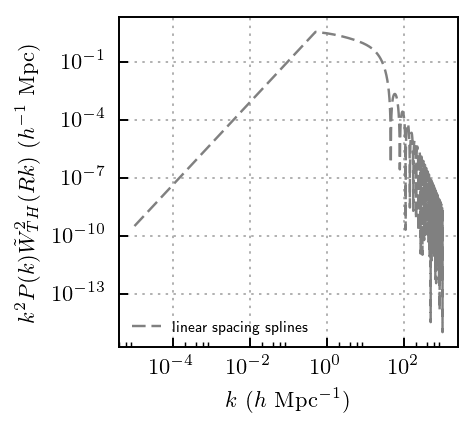

In [15]:
# plot the linear-spacing spline
Nsp = 2000; R = 1.e-1
k = np.linspace(kmin, kmax, Nsp)
fklin = linfpwsp(k, R)
fsplin = UnivariateSpline(k, fklin, s=0.)

print("R = %.3e, Nsp = %d"%(R, Nsp))
plt.figure(figsize=(2.5,2.5))
plt.xlabel(r'$k\ (h\ \mathrm{Mpc^{-1}})$'); plt.ylabel(r'$k^2 P(k) \tilde{W}_{TH}^2 (Rk)\ (h^{-1}\ \mathrm{Mpc})$')
plt.xscale('log'); plt.yscale('log')
plt.plot(k, fsplin(k), '--', linewidth=1., c='gray', label='linear spacing splines')
plt.legend(loc='lower left', frameon=False, fontsize=6)
plt.grid(ls='dotted')
plt.show()

R = 1.000e-01, Nsp = 200


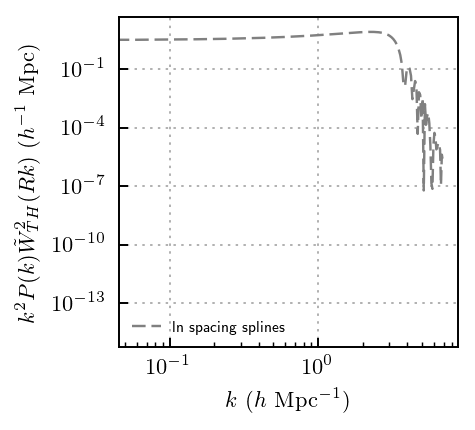

In [17]:
# plot the ln-spacing splineprint("ln spacing")
Nsp = 200; R = 1.e-1
lnk = np.linspace(lnkmin, lnkmax, Nsp)
fkln = lnfpwsp(lnk, R)
fspln = UnivariateSpline(lnk, fkln, s=0.)

print("R = %.3e, Nsp = %d"%(R, Nsp))
plt.figure(figsize=(2.5,2.5))
plt.xlabel(r'$k\ (h\ \mathrm{Mpc^{-1}})$'); plt.ylabel(r'$k^2 P(k) \tilde{W}_{TH}^2 (Rk)\ (h^{-1}\ \mathrm{Mpc})$')
plt.xscale('log'); plt.yscale('log')
plt.plot(lnk, fspln(lnk), '--', linewidth=1., c='gray', label='ln spacing splines')
plt.legend(loc='lower left', frameon=False, fontsize=6)
plt.grid(ls='dotted')
plt.show()

In [19]:
"""
Now, for various R values we will calculate sigma using splines integration in ln k spacing 
and a number N of tabulated points.
"""
# number of points
Nsp = 1000
# number of R values
NR = 100
# rtol for our Romberg integration routine
rtol= 1.e-7

# ln spacing for R:
Rmin = 1.e-2; Rmax = 1.e+3
lnRmin = np.log(Rmin); lnRmax = np.log(Rmax)
lnR = np.linspace(lnRmin, lnRmax, NR); Rln = np.e**lnR

# ln k spacing
kmin = 1.e-4; kmax = 1.e+3
lnkmin = np.log(kmin); lnkmax = np.log(kmax)
lnk = np.linspace(lnkmin, lnkmax, Nsp)

# linear k spacing
k = np.linspace(kmin, kmax, Nsp)

# initialize array of sigma splines integration with ln and linear spacing
sigmaRln = np.array( [0] * NR, float )
sigmaRlin = np.array( [0] * NR, float )
# initialize array of sigma integration with our and scipy's Romberg routines
sigmaRromb = np.array( [0] * NR, float )
sigmaRpy = np.array( [0] * NR, float )

for i in range(NR):
    fkln = lnfpwsp(lnk, Rln[i])
    fspln = UnivariateSpline(lnk, fkln, s=0.)
    lnfsp = fspln.integral(lnkmin, lnkmax)
    sigmaRln[i] = np.sqrt(lnfsp)
  
    fklin = linfpwsp(k, Rln[i])
    fsplin = UnivariateSpline(k, fklin, s=0.)
    linfsp = fsplin.integral(kmin, kmax)
    sigmaRlin[i] = np.sqrt(linfsp)
    
    RombInt = romberg(lnfpwsp, lnkmin, lnkmax, rtol, Rln[i])
    ScipyInt = integrate.romberg(lnfpwsp, lnkmin, lnkmax, args=(Rln[i],),tol=rtol)
    sigmaRromb[i], m = np.sqrt(RombInt)
    sigmaRpy[i] = np.sqrt(ScipyInt)

In [20]:
# calculation of fractional errors between:
# 1) our Romberg and splines with linear spacing: I(romberg)/I(splines) - 1
# 2) our Romberg and splines with ln spacing: I(romberg)/I(splines) - 1
# 3) scipy's Romberg and splines with linear spacing: I(romberg)/I(splines) - 1
# 4) scipy's Romberg and splines with ln spacing: I(romberg)/I(splines) - 1

frerr_romb_lin = np.array( [0] * NR, float )
frerr_romb_ln = np.array( [0] * NR, float )
frerr_scipy_lin = np.array( [0] * NR, float )
frerr_scipy_ln = np.array( [0] * NR, float )

for i in range(NR):
    frerr_romb_lin[i] = sigmaRromb[i]/sigmaRlin[i] - 1.
    frerr_romb_ln[i] = sigmaRromb[i]/sigmaRln[i] - 1.
    frerr_scipy_lin[i] = sigmaRpy[i]/sigmaRlin[i] - 1.
    frerr_scipy_ln[i] = sigmaRpy[i]/sigmaRln[i] - 1.

Number of points in splines = 1000


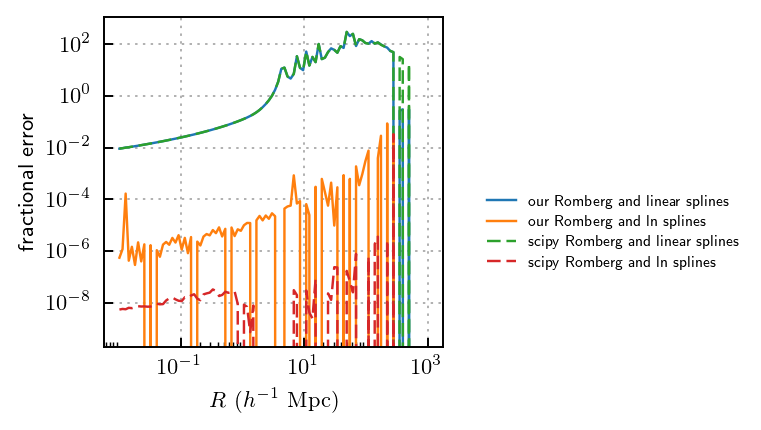

In [21]:
# plot of above fractional errors
print("Number of points in splines = %d"%(Nsp))

plt.figure(figsize=(2.5,2.5))
plt.xlabel(r'$R\ (h^{-1}\ \mathrm{Mpc})$'); plt.ylabel(r'fractional error')
plt.xscale('log'); plt.yscale('log')
plt.plot(Rln, frerr_romb_lin, linewidth=1., label='our Romberg and linear splines')
plt.plot(Rln, frerr_romb_ln, linewidth=1., label='our Romberg and ln splines')
plt.plot(Rln, frerr_scipy_lin, '--', linewidth=1., label='scipy Romberg and linear splines')
plt.plot(Rln, frerr_scipy_ln, '--', linewidth=1., label='scipy Romberg and ln splines')
plt.legend(loc=9, bbox_to_anchor=(1.5, 0.5), frameon=False, fontsize=6)
plt.grid(ls='dotted')
plt.show()

As we can see, linear splines produce quite inaccurate results, especially for larger $R$ values, compared to ours and scipy's Romberg routines. The splines with ln k spacing produce results much closer to the two Romberg integration routines, although the results seem to agree better with the latter routine. Below we also present the actual results for all four methods together.

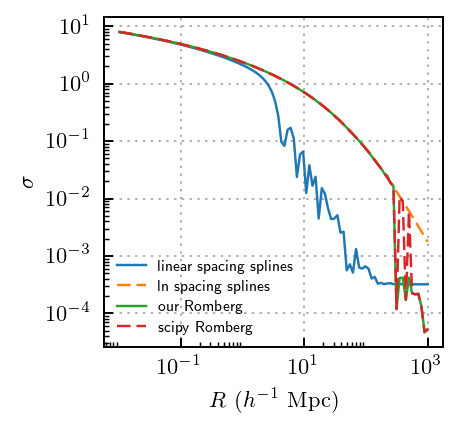

In [22]:
# plot sigma(R) from above calculations
plt.figure(figsize=(2.5,2.5))
plt.xlabel(r'$R\ (h^{-1}\ \mathrm{Mpc})$'); plt.ylabel(r'$\sigma$')
plt.xscale('log'); plt.yscale('log')
plt.plot(Rln, sigmaRlin, linewidth=1., label='linear spacing splines')
plt.plot(Rln, sigmaRln, '--', linewidth=1., label='ln spacing splines')
plt.plot(Rln, sigmaRromb, linewidth=1., label='our Romberg')
plt.plot(Rln, sigmaRpy, '--', linewidth=1., label='scipy Romberg')
plt.legend(loc='lower left', frameon=False, fontsize=6)
plt.grid(ls='dotted')
plt.show()

Ex 2c - Inverse spline

We will use the splines we constructed with ln k spacing above and reverse it to compute $R(\sigma)$.

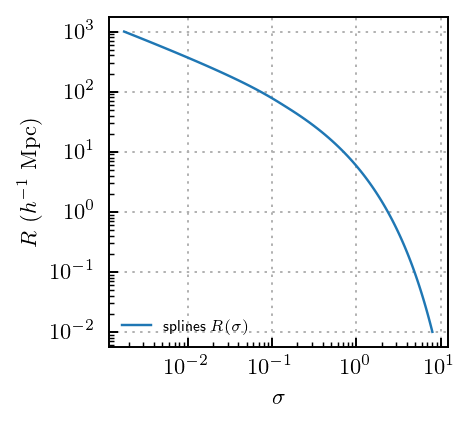

In [23]:
# choose a spline interpolation
sigmaR = sigmaRln
# use these values to spline the values of R(sigma).
# first make sure sigma is in increasing order
sigma = sigmaR[::-1]
R = Rln[::-1]

# spline thye new points
Rsigma = UnivariateSpline(sigma, R, s=0.)

# plot splines
plt.figure(figsize=(2.5,2.5))
plt.xlabel(r'$\sigma$'); plt.ylabel(r'$R\ (h^{-1}\ \mathrm{Mpc})$')
plt.xscale('log'); plt.yscale('log')
plt.plot(sigma, Rsigma(sigma), linewidth=1., label='splines $R(\sigma)$')
plt.legend(loc='lower left', frameon=False, fontsize=6)
plt.grid(ls='dotted')
plt.show()

In [24]:
# we can now interpolate for sigma = 1.69 (using h = 0.7)
sigma0 = 1.69
h = 0.7
print("sigma = %.2f at for R = %.3f Mpc"%(sigma0, Rsigma(sigma0)/h))

sigma = 1.69 at for R = 3.119 Mpc


Thus, at radius $R \approx 3.12 \; Mpc$ the density fluctuation take the value of $\sigma = 1.69$, for $h = 0.7$. This radius is comparable with the size of a galaxy cluster.

Ex 2d - Parallel Romberg routine

We now want to parallelize our Romberg routine by spliting the integration interval into $N_p$ sub-interavals and simultaniously running our routine for each of them. We also want to run this code in Midway and test what happens when we use many cores at the same time. This cose can be seen in the file "romb_mpi.py". Below are some results when we run the code.

In [25]:
# keep error tolerance constant
rtol = 1.e-8
# testing for different values of R
R = [1.e-2, 1.e-1, 1.e0, 1.e+1, 1.e+2, 1.e+3]
Np = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# R = 1.e-2
# times -> rows:Np, columns:dt (time of calculation)
times1 = np.array( [[0] * len(Np)] * len(Np), float )
times1 = [9.099e-2/9.025e-02, 9.099e-2/8.977e-2, 9.099e-2/5.331e-2, 9.099e-2/5.354e-2, 9.099e-2/4.834e-2,\
          9.099e-2/5.408e-2, 9.099e-2/5.197e-2, 9.099e-2/5.284e-2, 9.099e-2/5.355e-2, 9.099e-2/5.343e-2]

# R = 1.e-1
# times -> rows:Np, columns:dt (time of calculation)
times2 = np.array( [[0] * len(Np)] * len(Np), float )
times2 = [9.025e-02/9.025e-02, 9.025e-02/5.243e-2, 9.025e-02/5.170e-2, 9.025e-02/5.374e-2, 9.025e-02/5.184e-2, \
         9.025e-02/4.594e-2, 9.025e-02/3.432e-2, 9.025e-02/5.208e-2, 9.025e-02/5.369e-2, 9.025e-02/5.340e-2]

# R = 1.e0
# times -> rows:Np, columns:dt (time of calculation)
times3 = np.array( [[0] * len(Np)] * len(Np), float )
times3 = [9.132e-02/9.132e-02, 9.132e-02/9.050e-2, 9.132e-02/5.712e-2, 9.132e-02/5.302e-2, 9.132e-02/5.326e-2, \
         9.132e-02/4.613e-2, 9.132e-02/5.250e-2, 9.132e-02/5.198e-2, 9.132e-02/5.258e-2, 9.132e-02/5.320e-2]

# R = 1.e+1
# times -> rows:Np, columns:dt (time of calculation)
times4 = np.array( [[0] * len(Np)] * len(Np), float )
times4 = [9.181e-02/9.181e-02, 9.181e-02/5.305e-2, 9.181e-02/5.323e-2, 9.181e-02/5.317e-2, 9.181e-02/5.274e-2, \
         9.181e-02/5.275e-2, 9.181e-02/4.638e-2, 9.181e-02/3.485e-2, 9.181e-02/4.352e-2, 9.181e-02/4.733e-2]

# R = 1.e+2
# times -> rows:Np, columns:dt (time of calculation)
times5 = np.array( [[0] * len(Np)] * len(Np), float )
times5 = [3.759e-02/3.759e-02, 3.759e-02/3.337e-2, 3.759e-02/3.323e-2, 3.759e-02/3.395e-2, 3.759e-02/2.592e-2, \
         3.759e-02/2.514e-2, 3.759e-02/2.567e-2, 3.759e-02/2.470e-2, 3.759e-02/2.480e-2, 3.759e-02/2.582e-2]

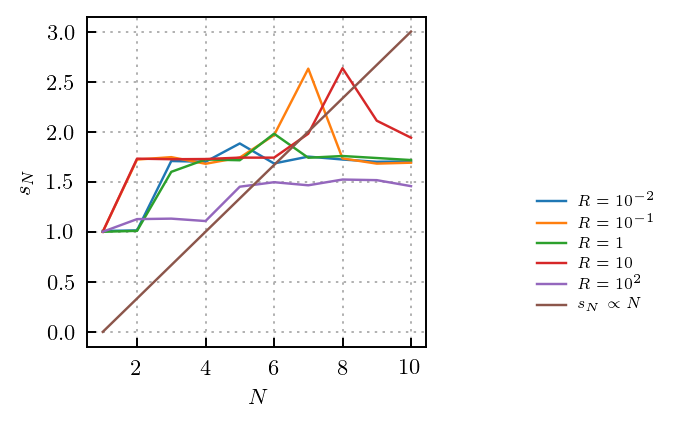

In [27]:
import matplotlib.pyplot as plt
# plot of above fractional errors
plt.figure(figsize=(2.5,2.5))
plt.xlabel(r'$N$'); plt.ylabel(r'$s_N$')
#plt.xscale('log'); plt.yscale('log')
plt.plot(Np, times1, linewidth=1., label='$R = 10^{-2}$')
plt.plot(Np, times2, linewidth=1., label='$R = 10^{-1}$')
plt.plot(Np, times3, linewidth=1., label='$R = 1$')
plt.plot(Np, times4, linewidth=1., label='$R = 10$')
plt.plot(Np, times5, linewidth=1., label='$R = 10^2$')
plt.plot(np.linspace(1,10), np.linspace(2/3,9/3), linewidth=1., label='$s_N \propto N$')
plt.legend(loc=9, bbox_to_anchor=(1.5, 0.5), frameon=False, fontsize=6)
plt.grid(ls='dotted')
plt.show()

We can see that at first, when increasing the number of cores the integration is carried out faster. But after a certain point, as we further increase the number of cores the code's speed-up is insignificant. Also, $s_n = t_1/t_N$ does not seem to behave like $\propto N$, but it undergoes a quick speed-up followed by a somewhat constant speed for larger number of cores.

*Note: I know I should have found a better way to plot the above figure than writing down each result, but I encountered an issue with trasfering some files to my computer, which I will try to solve in the weekend when I find some time.